In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional,Dropout, Activation, GRU
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [2]:
train_data = pd.read_csv('Train_DataSet.csv',encoding='ANSI')
train_label = pd.read_csv('Train_DataSet_Label.csv')
train = pd.merge(train_data, train_label, how='left', on='id')
train = train[(train.label.notnull()) & (train.content.notnull())]
test = pd.read_csv('Test_DataSet.csv')

train['title'] = train['title'].fillna('')
train['content'] = train['content'].fillna('')
test['title'] = test['title'].fillna('')
test['content'] = test['content'].fillna('')

In [3]:
import re
def filter(text):
    text = re.sub("[A-Za-z0-9\!\=\？\%\[\]\,\（\）\>\<:&lt;\/#\. -----\_]", "", text)
    text = text.replace('图片', '')
    text = text.replace('\xa0', '') # 删除nbsp
    # new
    r1 =  "\\【.*?】+|\\《.*?》+|\\#.*?#+|[.!/_,$&%^*()<>+""'?@|:~{}#]+|[——！\\\，。=？、：“”‘’￥……（）《》【】]"
    cleanr = re.compile('<.*?>')
    text = re.sub(cleanr, ' ', text)        #去除html标签
    text = re.sub(r1,'',text)
    text = text.strip()
    return text


In [4]:
def clean_text(data):
    data['title'] = data['title'].apply(lambda x: filter(x))
    data['content'] = data['content'].apply(lambda x: filter(x))
    return data
train = clean_text(train)
test = clean_text(test)

In [ ]:
def get_stopwords(stop_word_file):
    with open(stop_word_file,encoding='UTF-8') as f:
        stopwords=f.read()
    stopwords_list=stopwords.split('\n')
    custom_stopwords_list=[i for i in stopwords_list]
    return custom_stopwords_list

In [6]:
import jieba
import string
def cut_text(sentence):
    tokens = list(jieba.cut(sentence))
    # 去除停用词
    tokens = [token for token in tokens if token not in get]
#     # 去除英文标点
#     tokens = [w.translate(table) for w in tokens]
    return tokens

In [7]:
train_title = [cut_text(sent) for sent in train.title.values]
train_content = [cut_text(sent) for sent in train.content.values]
test_title = [cut_text(sent) for sent in test.title.values]
test_content = [cut_text(sent) for sent in test.content.values]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\a\AppData\Local\Temp\jieba.cache
Loading model cost 1.149 seconds.
Prefix dict has been built successfully.


In [8]:
all_doc = train_title + train_content + test_title + test_content

In [9]:
import gensim
import time
class EpochSaver(gensim.models.callbacks.CallbackAny2Vec):
    '''用于保存模型, 打印损失函数等等'''
    def __init__(self, save_path):
        self.save_path = save_path
        self.epoch = 0
        self.pre_loss = 0
        self.best_loss = 999999999.9
        self.since = time.time()

    def on_epoch_end(self, model):
        self.epoch += 1
        cum_loss = model.get_latest_training_loss() # 返回的是从第一个epoch累计的
        epoch_loss = cum_loss - self.pre_loss
        time_taken = time.time() - self.since
        print("Epoch %d, loss: %.2f, time: %dmin %ds" % 
                    (self.epoch, epoch_loss, time_taken//60, time_taken%60))
        if self.best_loss > epoch_loss:
            self.best_loss = epoch_loss
            print("Better model. Best loss: %.2f" % self.best_loss)
            model.save(self.save_path)
            print("Model %s save done!" % self.save_path)

        self.pre_loss = cum_loss
        self.since = time.time()
# model_word2vec = gensim.models.Word2Vec.load('final_word2vec_model')

In [10]:
model_word2vec = gensim.models.Word2Vec(min_count=1, 
                                        window=5, 
                                        vector_size=256,
                                        workers=4,
                                        batch_words=1000)
since = time.time()
#根据all_doc(title+train建立词典)
model_word2vec.build_vocab(all_doc, progress_per=2000)
time_elapsed = time.time() - since
print('Time to build vocab: {:.0f}min {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Time to build vocab: 0min 8s


In [12]:
since = time.time()
model_word2vec.train(all_doc, total_examples=model_word2vec.corpus_count, 
                        epochs=20, compute_loss=True, report_delay=60*10,
                        callbacks=[EpochSaver('./final_word2vec_model')])
time_elapsed = time.time() - since
print('Time to train: {:.0f}min {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1, loss: 3537066.00, time: 0min 10s
Better model. Best loss: 3537066.00
Model ./final_word2vec_model save done!
Epoch 2, loss: 2571392.00, time: 0min 9s
Better model. Best loss: 2571392.00
Model ./final_word2vec_model save done!
Epoch 3, loss: 2172988.00, time: 0min 9s
Better model. Best loss: 2172988.00
Model ./final_word2vec_model save done!
Epoch 4, loss: 1720656.00, time: 0min 9s
Better model. Best loss: 1720656.00
Model ./final_word2vec_model save done!
Epoch 5, loss: 1678450.00, time: 0min 9s
Better model. Best loss: 1678450.00
Model ./final_word2vec_model save done!
Epoch 6, loss: 1446310.00, time: 0min 9s
Better model. Best loss: 1446310.00
Model ./final_word2vec_model save done!
Epoch 7, loss: 1479100.00, time: 0min 9s
Epoch 8, loss: 1404266.00, time: 0min 9s
Better model. Best loss: 1404266.00
Model ./final_word2vec_model save done!
Epoch 9, loss: 1250414.00, time: 0min 9s
Better model. Best loss: 1250414.00
Model ./final_word2vec_model save done!
Epoch 10, loss: 104029

In [13]:
tokenizer = Tokenizer()
#tokenizer.fit_on_texts(train_title + test_title)
tokenizer.fit_on_texts(train_content + test_content)

In [14]:
# 转化成词向量矩阵，利用新的word2vec模型
vocab_size = len(tokenizer.word_index)
error_count=0
embedding_matrix = np.zeros((vocab_size + 1, 256))
for word, i in tqdm(tokenizer.word_index.items()):
    vocab = model_word2vec.wv
    if word in vocab:
        embedding_matrix[i] = model_word2vec.wv[word]
    else:
        error_count += 1

100%|██████████| 253129/253129 [00:01<00:00, 155482.48it/s]


In [35]:
print(embedding_matrix.shape)

(32056, 256)


In [15]:
# sequence = tokenizer.texts_to_sequences(train_title)
# traintitle = pad_sequences(sequence, maxlen=30)
# sequence = tokenizer.texts_to_sequences(test_title)
# testtitle = pad_sequences(sequence, maxlen=30)
sequence = tokenizer.texts_to_sequences(train_content)
traincontent = pad_sequences(sequence, maxlen=512)
sequence = tokenizer.texts_to_sequences(test_content)
testcontent = pad_sequences(sequence, maxlen=512)

# BaseLine

In [16]:
import tensorflow as tf
def metric_F1score(y_true,y_pred):    
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    F1score=2*precision*recall/(precision+recall)
    return F1score

In [23]:
import keras
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                    output_dim=256, 
                    input_length=30, 
                    weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.1)))
model.add(Dense(10))
model.add(Dropout(0.35))
model.add(Dense(3, activation='softmax'))
optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.5, 
#                                             min_lr=0.00001)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 256)           64801280  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 33        
Total params: 64,966,955
Trainable params: 64,966,955
Non-trainable params: 0
_________________________________________________________________


In [34]:
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                    output_dim=256, 
                    input_length=512, 
                    weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(3, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 512, 256)          64801280  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512, 64)           73984     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                1300      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 63        
Total params: 64,876,627
Trainable params: 64,876,627
Non-trainable params: 0
__________________________________________

In [35]:
label = train['label'].astype(int)
train_X, val_X, train_Y, val_Y = train_test_split(traincontent, label, shuffle=True, test_size=0.2,
                                                    random_state=2019)
val_y=val_Y
train_Y = to_categorical(train_Y)
val_Y=to_categorical(val_Y)

In [36]:
history = model.fit(train_X, train_Y, batch_size=32, epochs=10, 
                    verbose=True, validation_data=(val_X, val_Y))
 
#----------------------------------预测与可视化------------------------------
#预测
score = model.evaluate(val_X,val_Y, batch_size=32)
print('test loss:', score[0])
print('test accuracy:', score[1])

Epoch 1/10
182/182 [==============================] - 134s 712ms/step - loss: 0.8057 - accuracy: 0.6696 - val_loss: 0.6519 - val_accuracy: 0.7215
Epoch 2/10
182/182 [==============================] - 123s 677ms/step - loss: 0.5804 - accuracy: 0.7517 - val_loss: 0.6156 - val_accuracy: 0.7331
Epoch 3/10
182/182 [==============================] - 121s 665ms/step - loss: 0.4303 - accuracy: 0.8281 - val_loss: 0.6020 - val_accuracy: 0.7338
Epoch 4/10
182/182 [==============================] - 123s 676ms/step - loss: 0.2588 - accuracy: 0.9147 - val_loss: 0.6265 - val_accuracy: 0.7407
Epoch 5/10
182/182 [==============================] - 124s 683ms/step - loss: 0.1237 - accuracy: 0.9689 - val_loss: 0.6742 - val_accuracy: 0.7421
Epoch 6/10
182/182 [==============================] - 125s 685ms/step - loss: 0.0618 - accuracy: 0.9871 - val_loss: 0.7322 - val_accuracy: 0.7331
Epoch 7/10
182/182 [==============================] - 122s 670ms/step - loss: 0.0400 - accuracy: 0.9912 - val_loss: 0.8154 -

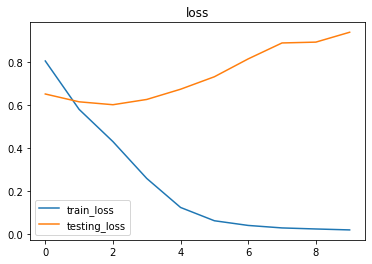

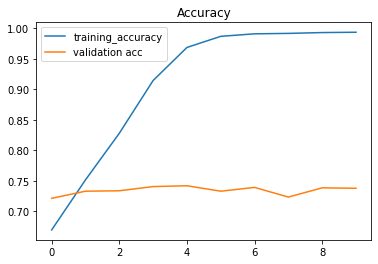

In [37]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [38]:
model.save('./model/embedding+LSTM.h5')

In [39]:
from keras.models import load_model
model=load_model('./model/embedding+LSTM.h5')

In [40]:
pre_y=np.argmax(model.predict(val_X),axis=1)
val_Y=val_y

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
test_accracy = accuracy_score(val_Y,pre_y)
F1_score=f1_score(val_Y,pre_y,average='macro')
Recall_score=recall_score(val_Y,pre_y,average='macro')
Precision_score=precision_score(val_Y,pre_y,average='macro')
print("Acc=",test_accracy)
print("Precision_score",Precision_score)
print("Recall_score",Recall_score)
print("F1_score",F1_score)


Acc= 0.7379642365887208
Precision_score 0.6865110398089335
Recall_score 0.6364000539123965
F1_score 0.6510558397994897


In [ ]:
model.summary()

In [ ]:
label = train['label'].astype(int)
# labels = to_categorical(label) 
# train_X, val_X, train_Y, val_Y = train_test_split(traintitle, label, shuffle=True, test_size=0.2,
#                                                     random_state=2019)
train_X, val_X, train_Y, val_Y = train_test_split(traintitle, label, shuffle=True, test_size=0.2,
                                                    random_state=2019)
train_Y = to_categorical(train_Y)


In [ ]:
model.fit(train_X,
          train_Y,
          batch_size=128,
          epochs=10)
# model.fit(traintitle,
#           labels,
#           batch_size=128,
#           epochs=3,
#           shuffle=True)

In [ ]:
from sklearn.metrics import f1_score
pred_val = model.predict(val_X)
print(f1_score(val_Y, np.argmax(pred_val, axis=1), average='macro'))


In [ ]:
test[test.label==0]

In [ ]:
test[['id', 'label']].to_csv('baseline4.csv', index=False)
